In [1]:
import pyscf
from pyscf import gto,dft,scf

# import neuralxc
# from neuralxc.projector.pyscf import get_eri3c as get_mlovlp
import torch
torch.set_default_dtype(torch.double)
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from net import * 
from torch_routines import * 
from utils import *
from losses import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
from atoms import *
%pylab inline


Populating the interactive namespace from numpy and matplotlib


/gpfs/home/smdick/miniconda3/envs/torch/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'eig']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
DEVICE='cpu'

In [3]:
x = XC_L(device=DEVICE,n_input=1, n_hidden=16, spin_scaling=True, use=[1], lob=True) # PBE_X
x2 = XC_L(device=DEVICE,n_input=1, n_hidden=16, spin_scaling=True, use=[1], lob=True) # PBE_X
# x.load_state_dict(torch.load('pbe_x_16_s_lob',map_location=torch.device('cpu')))

x_pbe = XC_L(device=DEVICE,n_input=1, n_hidden=16, spin_scaling=True, use=[1], lob=True) # PBE_X
x_pbe.load_state_dict(torch.load('pbe_new/pbe_x_16_new',map_location=torch.device('cpu')))

c = C_L(device=DEVICE,n_input=3, n_hidden=16, use=[2])
c2 = C_L(device=DEVICE,n_input=3, n_hidden=16, use=[2])
# c.load_state_dict(torch.load('pbe_c_16_gated',map_location=torch.device('cpu')))

c_pbe = C_L(device=DEVICE,n_input=3, n_hidden=16, use=[2])
c_pbe.load_state_dict(torch.load('pbe_new/pbe_c_16_new',map_location=torch.device('cpu')))

xc_pbe = XC(grid_models=[x_pbe, c_pbe], heg_mult=True, level=2)
# xc = XC(grid_models=[x, c], heg_mult=True, level=2)
xc = XC(grid_models=[x, c], heg_mult=True, level=2, exx_a = 0, model_mult=[1,1])
xc2 = XC(grid_models=[x2, c2], heg_mult=True, level=2)


# xc_pbe.load_state_dict(torch.load('log_trial5/2020-11-30_10:03:26.033684_1.chkpt',map_location=torch.device('cpu')))
xc2.load_state_dict(torch.load('log_trial6/2020-12-01_09:11:42.457279_2.chkpt',map_location=torch.device('cpu')))
# xc.load_state_dict(torch.load('log_large/2020-12-18_04:15:54.657880_val.chkpt',map_location=torch.device('cpu')))
xc.load_state_dict(torch.load('log_large_xx/2020-12-21_15:28:19.107623_val.chkpt',map_location=torch.device('cpu')))
x_pbe = xc_pbe.grid_models[0]
c_pbe = xc_pbe.grid_models[1]

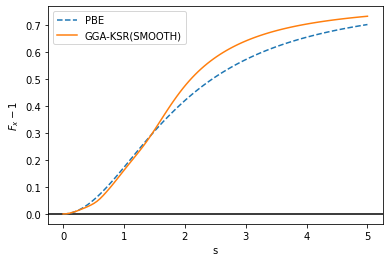

In [8]:
axhline(0,color='black')

# s = torch.exp(torch.linspace(-4,5,100).unsqueeze(-1))
# xscale('log')

s = torch.linspace(0,5,100).unsqueeze(-1)
s_inp = (1-torch.exp(-s**2/1))*torch.log(s+1)
#     s_inp = torch.log(s + 1e-3)
rho = torch.zeros_like(s)+1

inp = torch.cat([rho,s_inp],dim=-1)

#     plot(s, x_pbe(inp).detach().numpy(),label='alpha={}'.format(a),color='C{}'.format(idx))
#     plot(s, x(inp).detach().numpy(),label='alpha={}'.format(a),color='C{}'.format(idx),ls='-')
plot(s, x_pbe(inp).detach().numpy(),ls='--',label='PBE')
plot(s, x(inp).detach().numpy(),ls='-', label='GGA-KSR(SMOOTH)')
#     plot(s, x(inp).detach().numpy(),label='KSR')
# plot(s, 1.17*torch.sigmoid(torch.log(s)).detach().numpy())


xlabel('s')
ylabel('$F_x-1$')
legend()
# savefig('figs/Fx_gga.pdf', bbox_inches='tight')
# savefig('figs/Fx_gga.png', bbox_inches='tight')

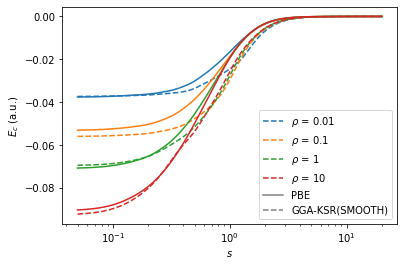

In [5]:
# for idx, rho_val in enumerate([0.001]):
# for idx, rho_val in enumerate([0.0001,0.001,0.01,0.1]):
for idx, rho_val in enumerate([0.01,0.1,1,10]):
    s = torch.linspace(-3,3,1000)

    s = torch.exp(s)
    
    s_inp = (1-torch.exp(-s**2/1))*torch.log(s+1)
    
    zeta = torch.Tensor([0]*len(s_inp))
    spinscale =0.5*((1+zeta)**(4/3) + (1-zeta)**(4/3))

    rho = torch.log(torch.Tensor([rho_val**(1/3)]*len(s))+1e-3)

    inp = torch.stack([rho, spinscale, s_inp],dim=-1)
    plot(s, c_pbe(inp).detach().numpy(),ls='-')
    plot(s, c(inp).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),color='C{}'.format(idx), ls='--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-KSR(SMOOTH)',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
xscale('log')
xlabel('$s$')
ylabel('$E_c$ (a.u.)')
legend()
# savefig('figs/Ec_gga.pdf', bbox_inches='tight')
# savefig('figs/Ec_gga.png', bbox_inches='tight')

Text(0, 0.5, '$E_c$')

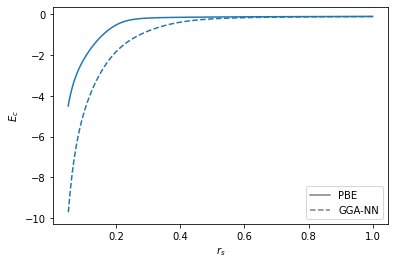

In [6]:
for idx, rho_val in enumerate([0.01]):
    s = torch.linspace(1,20,100)

#     s = torch.exp(s)
    
#     s = 0
    spinscale = torch.Tensor([1]*len(s))
    
    rho = torch.log(torch.exp(s)+1e-3)
    
    inp = torch.stack([rho, spinscale, torch.zeros_like(rho)],dim=-1)
#     plot(s, c_pbe(inp).detach().numpy(),ls='-')
#     plot(s, c(inp).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),color='C{}'.format(idx), ls='--')
    plot(1/s, c_pbe(inp).detach().numpy(),ls='-')
    plot(1/s, c(inp).detach().numpy(),color='C{}'.format(idx), ls='--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-NN',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
# xscale('log')
legend()
xlabel('$r_s$')
ylabel('$E_c$')
# savefig('figs/Ec_gga_rs.pdf', bbox_inches='tight')
# savefig('figs/Ec_gga_rs.png', bbox_inches='tight')

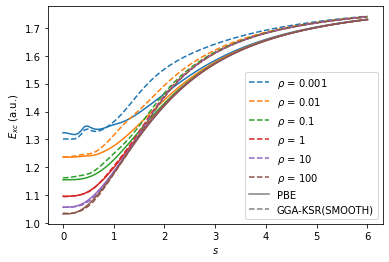

In [12]:
for idx, rho_val in enumerate([0.001,0.01,0.1,1,10,100]):
    s = torch.linspace(0,6,100)

#     s = torch.exp(s)
    
    s_inp = (1-torch.exp(-s**2/1))*torch.log(s+1)
    
    zeta = torch.Tensor([0]*len(s_inp))
    spinscale =0.5*((1+zeta)**(4/3) + (1-zeta)**(4/3))

    rho = torch.log(torch.Tensor([rho_val**(1/3)]*len(s))+1e-3)
    rho_pure = torch.Tensor([rho_val]*len(s))
    inp = torch.stack([rho, spinscale, s_inp],dim=-1)
    inp_x = torch.stack([rho, s_inp],dim=-1)
#     e_pbe = c_pbe(inp) + (1 + x_pbe(inp_x))*xc.heg_model(rho_pure)
#     e = c(inp) + (1 + x(inp_x))*xc.heg_model(rho_pure)
    e_pbe = (c_pbe(inp) + (1 + x_pbe(inp_x))*xc.heg_model(rho_pure))/xc.heg_model(rho_pure)
    e =  (c(inp) + (1 + x(inp_x))*xc.heg_model(rho_pure))/xc.heg_model(rho_pure)
#     e_pbe = -(1 + x_pbe(inp_x))
#     e =  -(1 + x(inp_x))
    plot(s, e_pbe.detach().numpy(),ls='-')
    plot(s, e.detach().numpy(), label='$\\rho$ = {}'.format(rho_val),color='C{}'.format(idx), ls='--')
plot([],label='PBE',color='gray',ls='-')
plot([],label='GGA-KSR(SMOOTH)',color='gray',ls='--')
#     plot(s, -c.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='--',color='C{}'.format(idx))
#     plot(s, -c_pbe.net(inp[...,c.use]).detach().numpy(), label='$\\rho$ = {}'.format(rho_val),ls='-',color='C{}'.format(idx))
# xscale('log')
xlabel('$s$')
ylabel('$E_{xc}$ (a.u.)')
legend()
# savefig('figs/Ec_gga.pdf', bbox_inches='tight')
# savefig('figs/Ec_gga.png', bbox_inches='tight')